# Import Libraries

In [1]:
import re
import json
import whois
import datetime
import numpy as np
from Cymon_API import *
import tldextract as tld
from urllib.parse import urlparse
#from seolib import get_alexa
from googlesearch import search

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')
import itertools
import graphviz 

/Users/andysun/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Define Functions

In [3]:
#Extract domain part of URL
def getDomain(url):
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    sfx = t_url.suffix
    if sdm == '':
        domain = dm+'.'+sfx
    else:
        domain = sdm+'.'+dm+'.'+sfx
    return domain

#1.1.1 Check if url contains an IP address
def is_ip(url):
    finder = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    check = finder.search(url)
    if check is not None:
        return 1
    return -1

#1.1.2 Check if URL is too long
def is_too_long(url):
    if(len(url)<54):
        return -1
    if(len(url)>=75):
        return 1
    else:
        return 0

#1.1.3 Check if URL is shortened
def is_shortened(url):
    if('bit.ly' in url):
        return 1
    return -1

#1.1.4 Check if URL contains @
def has_at(url):
    if('@' in url):
        return 1
    return -1

#1.1.5 Check if URL contains redirect
def has_redirect(url):
    finder = re.compile(r'//')
    fs = finder.search(url)
    if fs is None:
        return -1
    else:
        location = fs.end()
        if(location >7):
            return 1
    return -1

#1.1.6 Check if - is in domain name
def has_dash(url):
    extracted_url = tld.extract(url)
    if('-' in extracted_url.domain or '-' in extracted_url.subdomain):
        return 1
    return -1

#1.1.7 Check the number of subdomains
def has_multi_subdomain(url):
    finder = re.compile(r'www\.')
    url = finder.sub('',url)
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    dot_count = dm.count('.') + sdm.count('.') + (not sdm == '')+1
    if(dot_count == 1):
        return -1
    if(dot_count>2):
        return 1
    else:
        return 0

#1.1.8 Check if URL uses HTTPS
def has_https(url):
    #Get https certificate
    if 'https' in url:
        return 1
    return -1
    
#1.4.2, 1.4.1, 1.1.9 Check DNS record exists, age of domain, and time until expiration
def domain_features(url):
    out = [1,1,1]
    try:
        q = whois.query(getDomain(url))
        if q is not None:
            out[0] = -1
            today = datetime.datetime.now()
            creation_date = q.creation_date
            if creation_date is None:
                out[1] = 1
            else:
                age = (today-creation_date).days*1./365
                if(age <= 0.5):
                    out[1] = 1
                else:
                    out[1] = -1
            expiration_date = q.expiration_date
            if expiration_date is None:
                out[2] = 1
            else:
                lifetime = (expiration_date-today).days*1./365
                if(lifetime <= 1):
                    out[2] = 1
                else:
                    out[2] = -1
        else:
            out = [1,1,1]
    except:
        out = [1,1,1]
        
    return out

#1.4.2
def webTraffic(url):
    alexa_rank = seo.get_alexa(url)
    if alexa_rank is None:
        return 1
    elif alexa_rank < 100000:
        return -1
    else:
        return 0

#1.4.4
def googleIndex(url):
    try:
        result = search(url, num=1, stop=1, pause=2)
        if len(list(result)) == 0:
            return 1
        else:
            return -1
    except:
        return 1

#1.4.7 Check if domain is blacklisted   
def check_domain(url):
    finder = re.compile(r'www\.')
    url = finder.sub('',url)
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    sfx = t_url.suffix
    data = lookup_domain(sdm+'.'+dm+'.'+sfx)
    if data == None:
        return 1
    elif len(data)>1:
        return -1
    else:
        return 1

#1.1.12 Check if https is in domain name
def https_in_domain(url):
    dm = getDomain(url)
    if('https' in dm):
        return 1
    else:
        return -1

def getFeatures(url):
    whois_features = domain_features(url)
    features = [0]*11
    features[0] = is_ip(url)                 #1.1.1
    features[1] = is_too_long(url)           #1.1.2
    features[2] = is_shortened(url)          #1.1.3
    features[3] = has_at(url)                #1.1.4
    features[4] = has_redirect(url)          #1.1.5
    features[5] = has_dash(url)              #1.1.6
    features[6] = has_multi_subdomain(url)   #1.1.7
    features[7] = has_https(url)             #1.1.8
    #features[8] = whois_features[2]          #1.1.9
    features[8] = https_in_domain(url)       #1.1.12
    features[9] = whois_features[0]         #1.4.2
    features[10] = whois_features[1]         #1.4.1
    #features[11] = googleIndex(url)          #1.4.4
    #features[12] = check_domain(url)         #1.4.7
    return features

# Load UCI Dataset

In [7]:
data = []
with open('phishing_data.txt','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        data.append([float(i) for i in line.rstrip('\n').split(',')])
        
data = np.array(data)
print('Number of samples, Number of attributes')
print(len(data),len(data[0]),'\n')

nf = 9
train_size = 10000
test_size = 500
a = np.arange(0,nf).astype(int)
b = np.array([11,22,23,29]).astype(int)
idx = np.concatenate((a,b))
train = [data[0:train_size,idx],data[0:train_size,30]]
test = [data[train_size+1:train_size+test_size+1,idx],data[train_size+1:train_size+test_size+1,30]]

print('Training Set')
print('Number of negative examples')
print(np.sum(train[1]==-1)/len(train[1]))
print('Number of positive examples')
print(np.sum(train[1]==1)/len(train[1]))

print('\nTest Set')
print('Number of negative examples')
print(np.sum(test[1]==-1)/len(test[1]))
print('Number of positive examples')
print(np.sum(test[1]==1)/len(test[1]))

Number of samples, Number of attributes
11055 31 

Training Set
Number of negative examples
0.4437
Number of positive examples
0.5563

Test Set
Number of negative examples
0.448
Number of positive examples
0.552


# Train Classifiers

{'max_depth': 13}
Score:  0.892
Confusion:
 [[196  28]
 [ 26 250]]
(0.8992805755395683, 0.9057971014492754, 0.9025270758122743, None)
precision      recall        fscore


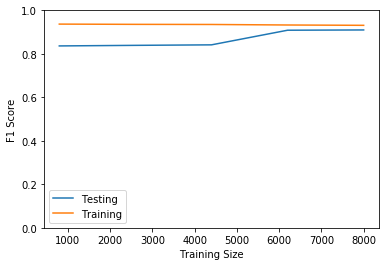

In [11]:
clf = tree.DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13]}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(train[0],train[1])
score = clf.best_estimator_.score(test[0],test[1])
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(test[1],clf.predict(test[0]))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(test[1],clf.best_estimator_.predict(test[0]), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(dt.best_estimator_,train[0],train[1],scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Testing','Training'])
plt.show()

In [9]:
clf = KNeighborsClassifier()
parameters = {'n_neighbors':[3,5]}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(train[0],train[1])
score = clf.best_estimator_.score(test[0],test[1])
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(test[1],clf.predict(test[0]))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(test[1],clf.best_estimator_.predict(test[0]), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(dt.best_estimator_,train[0],train[1],scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Testing','Training'])
plt.show()

NameError: name 'KNeighborsClassifier' is not defined

In [89]:
clf = MLPClassifier()
parameters = {'alpha':[.1,1,5],'hidden_layer_sizes': [x for x in itertools.product((7,13,50),repeat=2)],'learning_rate':['constant','invscaling','adaptive'],'solver':['lbfgs','sgd','adam']}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(train[0],train[1])
score = clf.best_estimator_.score(test[0],test[1])
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(test[1],clf.predict(test[0]))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(test[1],clf.best_estimator_.predict(test[0]), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(dt.best_estimator_,train[0],train[1],scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Testing','Training'])
plt.show()

KeyboardInterrupt: 

# Test UCI Trained Classifiers on Malware List and Alexa Top 500

In [18]:
bad_data = []
label = []

with open('bad_domains.txt','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        if(counter < 10):
            bad_data.append(line.rstrip('\n'))
            label.append(1)

with open('top500.csv','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        if(counter < 10):
            bad_data.append(line.rstrip('\n').split(',')[1])
            label.append(-1)
        
td = []
for c,v in enumerate(bad_data):
    f = getFeatures(v)
    td.append(f)
    print(c,end='\r')
    
td = np.array(td)
score = clf.best_estimator_.score(td,label)
print(score)

cm = confusion_matrix(label,clf.predict(td))
print('Confusion:\n',cm)

print('\n Precision Recall Fscore')
print(precision_recall_fscore_support(label,clf.best_estimator_.predict(td), average='binary'))

0.2
Confusion:
 [[ 0  0 10]
 [ 0  0  0]
 [ 0  6  4]]

 Precision Recall Fscore


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [21]:
mm = np.mean(train[0],axis = 0)
for i in mm:
    print('%.2f'%i,end=' ')
print('\n')
mm = np.mean(td,axis = 0)
for i in mm:
    print(i,end=' ')

0.35 -0.64 0.74 0.71 0.74 -0.74 0.04 0.25 -0.34 0.68 0.82 0.00 0.70 

-1.0 -0.9 -1.0 -1.0 -1.0 -0.5 -0.45 -1.0 -1.0 0.4 0.4 1.0 0.0 

# Load Malicious and Alexa Top 1 Million

In [9]:
mal = []
with open('bad_domains.txt','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
            mal.append(getDomain(line.rstrip('\n')))

alexa = []
label = []
with open('top-1m.csv','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        if(counter < 20000):
            entry = line.rstrip('\n').split(',')[1]
            alexa.append(entry)
            if entry in mal:
                label.append(1)
            else:
                label.append(0)

In [10]:
N = 10000
nn = 0
M = 1000
mm = 0
training = []
count = 0
for i in mal[0:N] + alexa[0:N-nn]:
    print(count,end='\r')
    training.append(getFeatures(i))
    count += 1
tl = np.concatenate((np.zeros(N),np.ones(N-nn)))
testing = []
for i in mal[N:N+M] + alexa[N-nn:N-nn+M-mm]:
    testing.append(getFeatures(i))
tt = np.concatenate((np.zeros(M),np.ones(M-mm)))

{'max_depth': 1}
Score:  0.6365
Confusion:
 [[280 720]
 [  7 993]]
(0.5796847635726795, 0.993, 0.732030962034648, None)
precision      recall        fscore


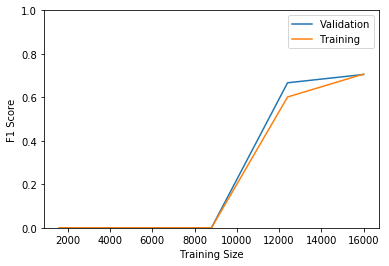

In [11]:
clf = tree.DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13]}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(training,tl)
score = clf.best_estimator_.score(testing,tt)
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(tt,clf.predict(testing))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(tt,clf.best_estimator_.predict(testing), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(dt.best_estimator_,training,tl,scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Validation','Training'])
plt.show()

In [14]:
dot_data = tree.export_graphviz(clf.best_estimator_,out_file=None, node_ids = True, proportion = True, class_names = True, filled = True, rounded = True)
graph = graphviz.Source(dot_data)

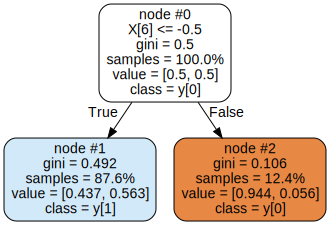

In [16]:
graph